# Core Imports and Setup

In [1]:
import os, re, glob
from pathlib import Path
from os import listdir
import numpy as np

import openff
from openff.evaluator.datasets import PhysicalPropertyDataSet

from openff.evaluator.forcefield import SmirnoffForceFieldSource
from openff.toolkit import ForceField
from openff.units import unit

# import logging
# logging.basicConfig(level=logging.DEBUG)

import warnings
warnings.filterwarnings("ignore")

# import logging
# logging.getLogger("openff.toolkit").setLevel(logging.ERROR)


from openff.units import unit

from matplotlib import pyplot

import matplotlib.pyplot as plt

from scipy.stats import linregress,zscore, pearsonr

from sklearn.metrics import mean_squared_error

# Loading ThermoML Data Sets

## Extracting data from ThermoML

In [2]:
from openff.evaluator.datasets import PhysicalProperty, PropertyPhase, PhysicalPropertyDataSet
from openff.evaluator.datasets.thermoml import thermoml_property, ThermoMLDataSet

data_set_initial = PhysicalPropertyDataSet.from_json("training-properties-with-water.json")
initial_df=data_set_initial.to_pandas()

In [3]:
# initial_df.to_csv(f'data_set_initial.csv')

In [4]:
print(len(data_set_initial))
print(data_set_initial.property_types)
print(data_set_initial.substances)

123
{'Density', 'EnthalpyOfMixing'}
{<Substance Cc1cccnc1{solv}{x=0.500000}|O{solv}{x=0.500000}>, <Substance CN1CCCCC1{solv}{x=0.790700}|O{solv}{x=0.209300}>, <Substance CN(C)CCCO{solv}{x=0.800600}|O{solv}{x=0.199400}>, <Substance OC1=NCCC1{solv}{x=0.769300}|O{solv}{x=0.230700}>, <Substance OCCN1CCOCC1{solv}{x=0.300200}|O{solv}{x=0.699800}>, <Substance CN(C)CCCO{solv}{x=0.289504}|O{solv}{x=0.710496}>, <Substance NCCCNCCCN{solv}{x=0.801500}|O{solv}{x=0.198500}>, <Substance OCC(O)CO{solv}{x=0.749360}|O{solv}{x=0.250640}>, <Substance NCCNCCO{solv}{x=0.069900}|O{solv}{x=0.930100}>, <Substance C1COCCN1{solv}{x=0.201000}|O{solv}{x=0.799000}>, <Substance CN(C)CCO{solv}{x=0.536500}|O{solv}{x=0.463500}>, <Substance CNCCO{solv}{x=0.199200}|O{solv}{x=0.800800}>, <Substance OCCNCCO{solv}{x=0.406700}|O{solv}{x=0.593300}>, <Substance CN(C)CCCO{solv}{x=0.501900}|O{solv}{x=0.498100}>, <Substance OCCOCCO{solv}{x=0.501000}|O{solv}{x=0.499000}>, <Substance CC(C)O{solv}{x=0.764357}|O{solv}{x=0.235643}>, <

## Filtering data set

In [5]:
from rdkit import Chem
from rdkit.Chem import FilterCatalog
from openff.evaluator.substances import Component, Substance

In [6]:
subs=list(set(data_set_initial.substances))
smiles_list=[]

for i in subs:
    comps=[]
    comps.append(i.components[0].smiles)
    comps.append(i.components[1].smiles)
    for o in comps:
        comps.remove('O')
        [smiles_list.append(y) for y in comps]

print(len(smiles_list))

120


In [7]:
def get_func_smiles(smiles_list):
    mols_list=[]

    for s in smiles_list:
        m=Chem.MolFromSmiles(s)
        mols_list.append(m)

    alcohols=[]
    amines=[]
    both=[]
    other=[]
    
    fc = FilterCatalog.GetFunctionalGroupHierarchy()
    for i in range(len(mols_list)):
        whtv=mols_list[i]
        if not fc.GetMatches(whtv):
            other.append(i)
        else:
            for match in fc.GetMatches(whtv):
                ffg=match.GetDescription()
                # print(i,ffg)
                if ffg == 'Amine':
                    amines.append(i)
                elif ffg == 'Alcohol':
                    alcohols.append(i)
                if i in amines and i in alcohols:
                    both.append(i)
                    amines.remove(i)
                    alcohols.remove(i)
    

    def get_smiles(func_type):
        smiles=[]

        for x in func_type:
            comp0=subs[x].components[0].smiles
            comp1=subs[x].components[1].smiles
            if comp0 != 'O':
                smiles.append(comp0)
            if comp1 != 'O':
                smiles.append(comp1)
            # smiles.append(comp0) 
            # smiles.append(comp1)
        smiles.append('O')
        return smiles

    smiles_results={}

    smiles_results['all']=smiles_list
    smiles_results['alcohols']=get_smiles(alcohols)
    smiles_results['amines']=get_smiles(amines)
    smiles_results['both']=get_smiles(both)
    smiles_results['other']=get_smiles(other)

    return smiles_results

    

In [8]:
smiles_results=get_func_smiles(smiles_list)

In [9]:
from openff.evaluator.datasets.curation.components.filtering import FilterByPropertyTypes, FilterByPropertyTypesSchema
from openff.evaluator.datasets.curation.components.filtering import FilterBySmiles, FilterBySmilesSchema

data_set_hmix_dens= FilterByPropertyTypes.apply(
    data_set_initial, FilterByPropertyTypesSchema(property_types=["EnthalpyOfMixing","Density"]))

print(len(data_set_hmix_dens))

data_set_alcohols= FilterBySmiles.apply(
    data_set_hmix_dens, FilterBySmilesSchema(smiles_to_include=smiles_results['alcohols']))

print(len(data_set_alcohols))

data_set_amines= FilterBySmiles.apply(
    data_set_hmix_dens, FilterBySmilesSchema(smiles_to_include=smiles_results['amines']))

print(len(data_set_amines))

data_set_both= FilterBySmiles.apply(
    data_set_hmix_dens, FilterBySmilesSchema(smiles_to_include=smiles_results['both']))

print(len(data_set_both))

data_set_other= FilterBySmiles.apply(
    data_set_hmix_dens, FilterBySmilesSchema(smiles_to_include=smiles_results['other']))

print(len(data_set_other))

123
18
33
62
10


In [10]:
print(set(smiles_results['all']))

{'CCCOC(C)=O', 'NCCNCCN', 'CCN(CC)CCO', 'CN(CCO)CCO', 'Cc1ccncc1', 'CN(C)CCO', 'OCCOCCO', 'CN(C)CCCO', 'OCCN1CCOCC1', 'NCCNCCO', 'OCCNCCO', 'Cc1cccnc1', 'NCCCNCCCN', 'OCC(O)CO', 'Cn1ccnc1', 'C1COCCN1', 'C1CCNCC1', 'CC(C)O', 'OC1=NCCC1', 'NCCCO', 'CN1CCNCC1', 'CN1CCCCC1', 'OCCN(CCO)CCO', 'CN1CCOCC1', 'CNCCO'}


In [11]:
# # save for future use

path=os.getcwd()

path_all=path+'/filtered_dataset_all.json'
data_set_hmix_dens.json(path_all, format=True)

# path_alcohols = path+'/filtered_dataset_alcohols.json'
# data_set_alcohols.json(path_alcohols, format=True)

# path_amines = path+'/filtered_dataset_amines.json'
# data_set_amines.json(path_amines, format=True)

# path_both = path+'/filtered_dataset_both.json'
# data_set_both.json(path_both, format=True)

# path_other = path+'/filtered_dataset_other.json'
# data_set_other.json(path_other, format=True)


# # inspect new properties
pandas_all = data_set_hmix_dens.to_pandas()
# pandas_alcohols = data_set_alcohols.to_pandas()
# pandas_amines = data_set_amines.to_pandas()
# pandas_both = data_set_both.to_pandas()
# pandas_other = data_set_other.to_pandas()

# Analysing Data Sets

In [12]:
force_field='Sage2.2.1'

### Plotting results all together

In [13]:
def analysis_all(
    phys_prop: str,
    water_model: str,                 # e.g. "OPC"
    functional_group: str,            # e.g. "all"
    base_dir: str = "watermix_analysis_reps",
    ff: str = f'{force_field}',
    aggregate: str = "mean",          # "mean" or "median"
    n_boot: int = 1000,               # bootstraps for CI
):

    # --- helpers ---
    def to_value(x, target_unit=None):
        if hasattr(x, "to"):
            try:
                return x.to(target_unit).magnitude if target_unit is not None else getattr(x, "magnitude", float(x))
            except Exception:
                return getattr(x, "magnitude", float(x))
        return float(x)

    # --- experimental (filter by phys_prop) ---
    experimental_path = f"filtered_dataset_{functional_group}.json"
    exp_ds = PhysicalPropertyDataSet.from_json(experimental_path)
    exp_props = [p for p in exp_ds if type(p).__qualname__ == phys_prop]
    if not exp_props:
        print(f"No experimental '{phys_prop}' found in {experimental_path}")
        return {}

    preferred_units = {
        "Density": unit.kilogram / unit.meter**3,
        "EnthalpyOfMixing": unit.kilojoule / unit.mole,
    }
    prop_type     = exp_props[0].__class__.__name__
    fallback_unit = getattr(exp_props[0].value, "units", None)
    preferred_unit = preferred_units.get(prop_type, fallback_unit)

    exp_ids  = [p.id for p in exp_props]
    exp_vals = [to_value(p.value, preferred_unit) for p in exp_props]

    # --- replicates: exactly results-r*.json in {base_dir}/{ff}/{water_model} ---
    folder = (Path(base_dir).expanduser() / ff / water_model).resolve()
    rep_paths = sorted(
        glob.glob(str(folder / "results-r*.json")),
        key=lambda p: int(re.search(r"results-r(\d+)\.json$", os.path.basename(p)).group(1))
              if re.search(r"results-r(\d+)\.json$", os.path.basename(p)) else 10**9
    )
    if not rep_paths:
        print(f"No replicate files found in '{folder}' matching 'results-r*.json'.")
        print(f"  cwd: {os.getcwd()}")
        print(f"  folder exists? {folder.exists()}")
        return {}

    # --- load & align each replicate ---
    def load_est_map(path):
        ds = PhysicalPropertyDataSet.from_json(path)
        out = {}
        for est in getattr(ds, "estimated_properties", []):
            try:
                out[est.id] = to_value(est.value, preferred_unit)
            except Exception:
                pass
        return out

    rep_names, rep_vals = [], []
    for p in rep_paths:
        rep_names.append(os.path.basename(p))
        idmap = load_est_map(p)
        rep_vals.append([idmap.get(pid, np.nan) for pid in exp_ids])

    rep_arr = np.array(rep_vals, dtype=float)  # (n_reps, n_points)

        # --- per-point replicate variability ---
    # counts of finite replicate values per point
    rep_counts = np.sum(np.isfinite(rep_arr), axis=0)

    # sample standard deviation across replicates (NaN if <2 reps)
    rep_std = np.nanstd(rep_arr, axis=0, ddof=1)

    # standard error of the mean across replicates (NaN if <2 reps)
    with np.errstate(invalid='ignore', divide='ignore'):
        rep_sem = rep_std / np.sqrt(rep_counts)

    # --- aggregate across replicates ---
    agg_fn  = np.nanmedian if aggregate.lower() == "median" else np.nanmean
    agg_vec = agg_fn(rep_arr, axis=0)

    # --- stats (with bootstrap CIs and outliers) ---
    def stats(x, y):
        x = np.asarray(x, float); y = np.asarray(y, float)
        m = np.isfinite(x) & np.isfinite(y)
        x, y = x[m], y[m]
        if x.size < 2:
            return {
                "n": int(x.size), "slope": np.nan, "intercept": np.nan, "r_value": np.nan,
                "r2": np.nan, "r2_bounds": (np.nan, np.nan), "p_value": np.nan,
                "std_err": np.nan, "rmse": np.nan, "rmse_bounds": (np.nan, np.nan),
                "outliers": np.array([], dtype=int)
            }

        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        preds = intercept + slope * x
        residuals = y - preds
        zscores = np.abs(zscore(residuals, nan_policy='omit'))
        outliers = np.where(zscores > 2.5)[0]

        # R^2 via Pearson (non-negative)
        r, _ = pearsonr(x, y)
        r2 = (r ** 2) if not np.isnan(r) else 0.0
        rmse = float(np.sqrt(mean_squared_error(x, y)))

        # Bootstrap CIs
        r2_list, rmse_list = [], []
        n = x.size
        for _ in range(n_boot):
            idx = np.random.randint(0, n, size=n)
            xb, yb = x[idx], y[idx]
            rb, _ = pearsonr(xb, yb)
            r2_list.append((rb ** 2) if not np.isnan(rb) else 0.0)
            rmse_list.append(float(np.sqrt(mean_squared_error(xb, yb))))
        r2_bounds  = (np.percentile(r2_list, 2.5),  np.percentile(r2_list, 97.5))
        rmse_bounds = (np.percentile(rmse_list, 2.5), np.percentile(rmse_list, 97.5))

        return {
            "n": int(x.size),
            "slope": slope, "intercept": intercept, "r_value": r_value,
            "r2": r2, "r2_bounds": r2_bounds,
            "p_value": p_value, "std_err": std_err,
            "rmse": rmse, "rmse_bounds": rmse_bounds,
            "outliers": outliers
        }

    agg_stats = stats(exp_vals, agg_vec)

    # --- build output with BOTH modern keys and legacy keys ---
    out = {
        "meta": {
            "phys_prop": phys_prop,
            "water_model": water_model,
            "functional_group": functional_group,
            "unit": str(preferred_unit) if preferred_unit is not None else None,
            "replicate_files": rep_paths,
            "replicate_names": rep_names,
            "aggregate": aggregate.lower(),
            "folder": str(folder),
            "n_boot": n_boot,
        },
        "ids": exp_ids,
        "experimental_values": exp_vals,
        "aggregate_estimated_values": agg_vec.tolist(),
        "aggregate_stats": agg_stats,
        "replicates": {
            name: {"estimated_values": vals, "stats": stats(exp_vals, vals)}
            for name, vals in zip(rep_names, rep_arr.tolist())
        },
    }

    out.update({
        "replicate_counts": rep_counts.tolist(),
        "replicate_std_values": rep_std.tolist(),
        "replicate_sem_values": rep_sem.tolist(),
    })
    
    # Legacy-style keys expected by existing plotting/consumers
    out[f"{water_model}:{phys_prop}-Experimental_Values"] = exp_vals
    out[f"{water_model}:{phys_prop}-Estimated_Values"]    = agg_vec.tolist()
    out[f"{water_model}:{phys_prop}-Stats"]               = agg_stats
    out[f"{water_model}:{phys_prop}-Estimated_Std"] = rep_std.tolist()
    out[f"{water_model}:{phys_prop}-Estimated_SEM"] = rep_sem.tolist()

    return out


In [14]:
# waters=('TIP3P','TIP3P_FB','TIP4P_Ew','TIP4P_FB','OPC','OPC3','GOPAL')
waters=['TIP3P','OPC3']

results_all=dict()
# results_alcohols=dict()
# results_amines=dict()
# results_both=dict()
# results_other=dict()

for w in waters:
    dens_result_all=analysis_all('Density', w, 'all',
                               base_dir=".", ff=f'{force_field}')
    results_all.update(dens_result_all)
    hmix_result_all=analysis_all('EnthalpyOfMixing',w,'all',
                               base_dir=".", ff=f'{force_field}')
    results_all.update(hmix_result_all)
    
    # dens_result_alcohols=analysis_all('Density', w, 'alcohols')
    # results_alcohols.update(dens_result_alcohols)
    # hmix_result_alcohols=analysis_all('EnthalpyOfMixing',w,'alcohols')
    # results_alcohols.update(hmix_result_alcohols)

    # dens_result_amines=analysis_all('Density', w, 'amines')
    # results_amines.update(dens_result_amines)
    # hmix_result_amines=analysis_all('EnthalpyOfMixing',w,'amines')
    # results_amines.update(hmix_result_amines)

    # dens_result_both=analysis_all('Density', w, 'both')
    # results_both.update(dens_result_both)
    # hmix_result_both=analysis_all('EnthalpyOfMixing',w,'both')
    # results_both.update(hmix_result_both)

    # dens_result_other=analysis_all('Density', w, 'other')
    # results_other.update(dens_result_other)



In [15]:
# Formatting font size
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

In [16]:
def plot_results_multi_model(
    results,
    water_models,                     # e.g., ["OPC", "OPC3", "TIP4P_Ew"]
    func,                             # "other" => Density only; anything else => Hmix + Density
    ff_label=f"OpenFF - {force_field}",
    color_map=None,
    save_prefix="hmix_dens",
    markers=None,                     # optional: per-model markers (cycled if shorter than water_models)
    sizes=None,                       # optional: [SMALL, MEDIUM, BIGGER]
):
    """
    Plot multiple models overlaid in the same figure per property.

    Expects keys in `results` like:
      '<MODEL>:<Prop>-Experimental_Values'
      '<MODEL>:<Prop>-Estimated_Values'
      '<MODEL>:<Prop>-Stats'
    where <Prop> in {"EnthalpyOfMixing", "Density"}.
    """

    default_colors = {
        "TIP3P": "r", "TIP3P_FB": "b", "TIP4P_Ew": "g", "TIP4P_FB": "c",
        "OPC": "m", "OPC3": "darkorange", "GOPAL": "indigo"
    }
    colors = (color_map or default_colors)

    # Cycle markers if provided; else use "x" for all
    if markers is None:
        markers = ["x"]
    def _get_marker(i):  # stable, but cycles
        return markers[i % len(markers)]

    def _vals(model, prop):
        """Fetch (x, y, stats, std_list) or None."""
        base = f"{model}:{prop}"
        x_key = f"{base}-Experimental_Values"
        y_key = f"{base}-Estimated_Values"
        s_key = f"{base}-Stats"
        std_key = f"{base}-Estimated_Std"   # <- added
        if x_key not in results or y_key not in results or s_key not in results:
            return None
        std_list = results.get(std_key, None)  # may be None if not provided
        return results[x_key], results[y_key], results[s_key], std_list

    def _label(model, stats, std_list):
        r2   = stats.get("r2", np.nan)
        rb   = stats.get("r2_bounds", (np.nan, np.nan))
        rm   = stats.get("rmse", np.nan)
        rmb  = stats.get("rmse_bounds", (np.nan, np.nan))

        # summarize replicate stdev across all points (ignore NaNs)
        if std_list is not None:
            std_arr = np.asarray(std_list, float)
            std_mean = float(np.nanmean(std_arr)) if np.isfinite(std_arr).any() else np.nan
            std_med  = float(np.nanmedian(std_arr)) if np.isfinite(std_arr).any() else np.nan
            stdev_line = f"\n$\\sigma_{{repl}}$={std_mean:.3g} (med {std_med:.3g})"
        else:
            stdev_line = ""  # graceful if not available

        return (
            f"$\\bf{{{model}}}$\n"
            f"$r^2$={r2:.3f} ({rb[0]:.2f}, {rb[1]:.2f})\n"
            f"RMSE={rm:.3f} ({rmb[0]:.2f}, {rmb[1]:.2f})"
            f"{stdev_line}"
        )

    def _scatter_multi(ax, prop, xlim=None, ylim=None, title=None, ylab=None):
        ax.axline(xy1=(0, 0), slope=1, color="k", linewidth=1)
        plotted_any = False
        for i, wm in enumerate(water_models):
            data = _vals(wm, prop)
            if data is None:
                continue
            x, y, stats, std_list = data  # <- unpack the std list
            color = colors.get(wm, "k")
            ax.plot(
                x, y,
                linestyle="None",
                marker=_get_marker(i),
                markersize=5,
                color=color,
                label=_label(wm, stats, std_list),  # <- pass into label
            )
            plotted_any = True
        if not plotted_any:
            ax.text(0.5, 0.5, f"No data for models: {', '.join(water_models)}\n({prop})",
                    ha="center", va="center", transform=ax.transAxes)

        if xlim: ax.set_xlim(*xlim)
        if ylim: ax.set_ylim(*ylim)

        # tick/labels
        ax.set_xticks(ax.get_xticks()); ax.set_yticks(ax.get_yticks())
        ax.tick_params(labelsize=SMALL_SIZE)
        if title: ax.set_title(title, fontsize=BIGGER_SIZE)
        ax.set_xlabel("Experimental Value", fontsize=MEDIUM_SIZE)
        if ylab: ax.set_ylabel(ylab, fontsize=MEDIUM_SIZE)

        # Legends can get tall; use smaller font and place outside if many models
        leg = ax.legend(
            prop={"size": 7 if prop != "Density" else 6},
            loc="lower right",
            frameon=True
        )
        leg._legend_box.align = "left"  # keep multi-line entries aligned

        # keep 1:1 visual scale helpful for parity plots
        try:
            ax.set_aspect('equal', adjustable='box')
        except Exception:
            pass

    # ---------- layout ----------
    if func == "other":
        # Density only
        fig, ax = plt.subplots(figsize=(7.0, 6.0))
        _scatter_multi(
            ax, "Density",
            xlim=(800, 1200), ylim=(800, 1200),
            title=r"Density $kg/m^{3}$",
            ylab=f"{ff_label} Estimated Value",
        )
        fig.tight_layout()
        plt.savefig(f"{save_prefix}.png", dpi=300)
        plt.show()
    else:
        # Hmix + Density in one row
        fig, axs = plt.subplots(1, 2, figsize=(16.0, 6.0))
        plt.subplots_adjust(wspace=0.1, hspace=0.1)

        _scatter_multi(
            axs[0], "EnthalpyOfMixing",
            xlim=(-5, 2.7), ylim=(-5, 2.7),
            title=r"$H_{mix}$ $kJ/mol$",
            ylab=f"{ff_label} Estimated Value",
        )

        _scatter_multi(
            axs[1], "Density",
            xlim=(780, 1300), ylim=(780, 1300),
            title=r"Density $kg/m^{3}$",
            ylab=f"{ff_label} Estimated Value",
        )

        fig.tight_layout()
        plt.savefig(f"{save_prefix}.png", dpi=300)
        plt.show()


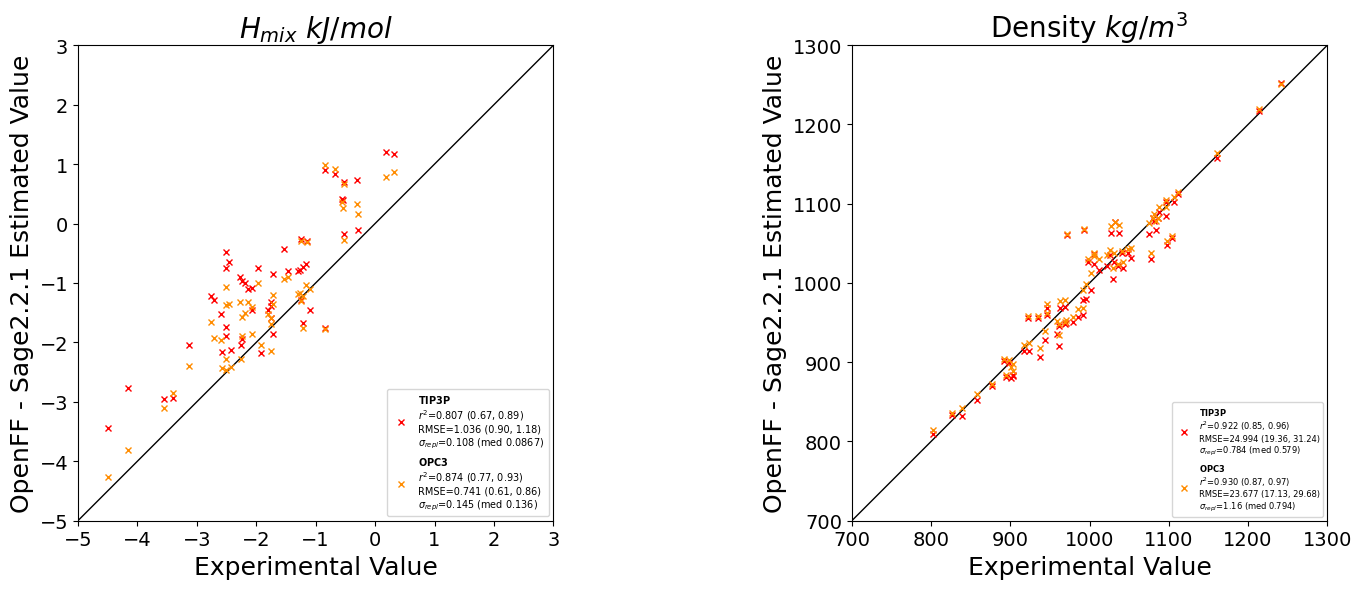

In [17]:
plot_results_multi_model(results_all, ["TIP3P","OPC3"], func="both", save_prefix="hmix_dens_bnmrk_all")

## RMSE

In [18]:
def rmse_figs(water_model,physprop,func_group_results):

    rmse =  func_group_results[f'{water_model}:{physprop}-Stats']
    rmse_lower = func_group_results[f'{water_model}:{physprop}-Stats']['rmse_bounds'][0]
    rmse_upper = func_group_results[f'{water_model}:{physprop}-Stats']['rmse_bounds'][1]

    # Error bars (asymmetric)
    error = [rmse_lower, rmse_upper]
    return rmse, error

In [19]:
for w in waters:
    rmse_hmix, error_hmix=rmse_figs(w,'EnthalpyOfMixing',results_all)
    rmse_dens, error_dens=rmse_figs(w,'Density',results_all)

In [20]:
# ---- Defaults ----
DEFAULT_MODELS = ['TIP3P', 'TIP3P_FB', 'TIP4P', 'TIP4P_FB', 'OPC', 'OPC3', 'GOPAL']

# Display name -> prefix used in results_all keys
RESULTS_PREFIX = {
    'TIP3P': 'TIP3P',
    'TIP3P_FB': 'TIP3P_FB',
    'TIP4P': 'TIP4P_Ew',   # <- results_all uses TIP4P_Ew
    'TIP4P_FB': 'TIP4P_FB',
    'OPC': 'OPC',
    'OPC3': 'OPC3',
    'GOPAL': 'GOPAL',
}

# Stable, model-specific colors (kept consistent across figures)
DEFAULT_COLORS = {
    'TIP3P': 'r',
    'TIP3P_FB': 'b',
    'TIP4P': 'g',
    'TIP4P_FB': 'c',
    'OPC': 'm',
    'OPC3': 'darkorange',
    'GOPAL': 'indigo',
}

def _fetch_rmse_and_bounds(results_all, model_display, property_name):
    """Safely fetch rmse and (lower, upper) bounds for a model/property from results_all.
       Returns None if the entry is missing."""
    prefix = RESULTS_PREFIX.get(model_display, model_display)
    key = f"{prefix}:{property_name}-Stats"
    try:
        stats = results_all[key]
        rmse = stats['rmse']
        lb, ub = stats['rmse_bounds']
        return float(rmse), float(lb), float(ub)
    except Exception:
        return None

def plot_rmse_by_model(
    results_all,
    properties=('EnthalpyOfMixing', 'Density'),
    water_models=None,                  # list like ['TIP3P','OPC'] or None for default/all
    ff_label='Sage 2.2.1',
    color_map=None,                     # dict model->color; defaults to DEFAULT_COLORS
    ylabel_map=None,                    # dict property->ylabel; defaults below
    save_prefix=None,                   # e.g. 'rmse_', files become 'rmse_EnthalpyOfMixing.png'
    show=True
):
    if water_models is None:
        water_models = DEFAULT_MODELS
    if color_map is None:
        color_map = DEFAULT_COLORS.copy()
    if ylabel_map is None:
        ylabel_map = {
            'EnthalpyOfMixing': r'RMSE',
            'Density': r'RMSE, $kg/m^{3}$',  # adjust if you keep units per property
        }

    for prop in properties:
        # Collect data in the requested order; skip missing gracefully
        labels, yvals, yerr_low, yerr_up, bar_colors = [], [], [], [], []
        for mdl in water_models:
            fetched = _fetch_rmse_and_bounds(results_all, mdl, prop)
            if fetched is None:
                # silently skip missing entries (or print a note)
                # print(f"[warn] Missing {mdl}:{prop}")
                continue
            rmse, lb, ub = fetched
            labels.append(mdl)
            yvals.append(rmse)
            yerr_low.append(lb)
            yerr_up.append(ub)
            bar_colors.append(color_map.get(mdl, 'gray'))

        # Nothing to plot?
        if not labels:
            print(f"[info] No data available for property '{prop}' with the selected models.")
            continue

        fig, ax = plt.subplots()
        ax.bar(labels, yvals, yerr=[yerr_low, yerr_up], capsize=10, color=bar_colors)

        # Labels & style
        ax.set_ylabel(ylabel_map.get(prop, 'RMSE'), fontsize=MEDIUM_SIZE)
        ax.set_title(f'{prop} RMSE - {ff_label}', fontsize=BIGGER_SIZE)
        ax.tick_params(axis='y', labelsize=SMALL_SIZE)
        ax.tick_params(axis='x', labelsize=SMALL_SIZE - 3)

        # Save show
        fname = f"{(save_prefix or '')}{prop.replace(' ', '_')}_rmse_all.png"
        plt.savefig(fname, bbox_inches='tight', dpi=200)
        if show:
            plt.show()
        else:
            plt.close(fig)



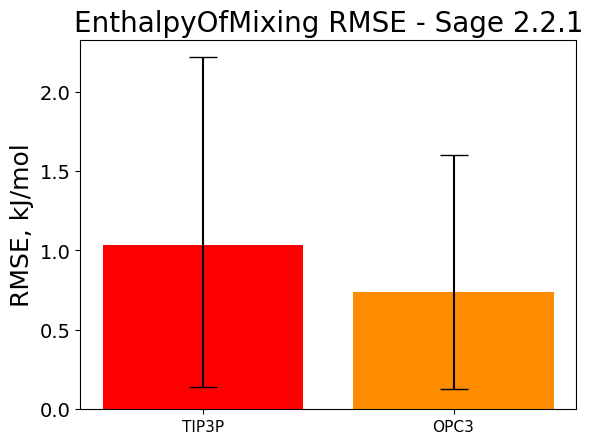

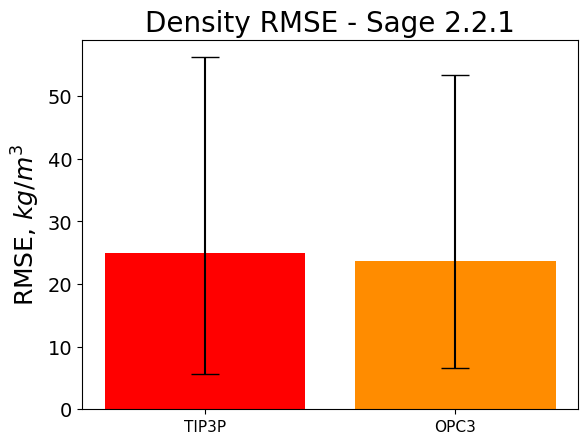

In [21]:
plot_rmse_by_model(
    results_all,
    properties=('EnthalpyOfMixing','Density'),
    water_models=['TIP3P','OPC','OPC3'],
    ff_label='Sage 2.2.1',
    ylabel_map={
        'EnthalpyOfMixing': r'RMSE, kJ/mol',
        'Density': r'RMSE, $kg/m^{3}$',
    },
    save_prefix='',                       # files: EnthalpyOfMixing_rmse_all.png, Density_rmse_all.png
    show=True
)
